In [1]:
import os
import json
import gzip
import pickle
import numpy as np

import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#nltk.download()
nltk.download('stopwords')
nltk.download('punkt')


#import more_itertools as mit
#from keras.preprocessing.sequence import pad_sequences

#from pytorch_pretrained_bert import BertTokenizer, BertModel
#from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/henning/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/henning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
def parse(path, chunk_size=20000):
    i = 0
    with gzip.open(path, 'rb') as f:
        for l in f:
            yield json.loads(l.strip())
            i+=1
            if i == chunk_size:
                break
def parse2(f):
    for l in f:
        yield json.loads(l.strip())        
            
def getDF(path, chunk_size):
    i = 0
    df = {}
    for d in parse(path, chunk_size):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def getDF_chunks(path, chunk_size, pkl_path, max_chunks=4):
    i = 0
    df = {}
    df_chunks = 0
    with gzip.open(path, 'rb') as f:
        for d in parse2(f):
            df[i] = d
            i+=1
            
            if i == chunk_size:
                df = pd.DataFrame.from_dict(df, orient='index')
                #preprocessing(df)
                df.to_pickle(pkl_path + "df" + str(df_chunks) +".pkl")
                df = {}
                i = 0
                df_chunks +=1
    return df_chunks, i

In [8]:
books_path = '../datasets/Books_5.json.gz'
chunk_size=40000
pkl_path = '../datasets/books-pickle/'

if False:
    df_chunks, i = getDF_chunks(books_path, chunk_size, pkl_path)
    print(df_chunks)

In [9]:
'''
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
df = getDF('meta_Computers.json.gz')
len(df)
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))
print("Remaining rows: {}".format(len(df5)))

'''

'\n!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz\ndf = getDF(\'meta_Computers.json.gz\')\nlen(df)\n### remove rows with unformatted title (i.e. some \'title\' may still contain html style content)\n\ndf3 = df.fillna(\'\')\ndf4 = df3[df3.title.str.contains(\'getTime\')] # unformatted rows\ndf5 = df3[~df3.title.str.contains(\'getTime\')] # filter those unformatted rows\nprint("Unformatted rows: {} ({:.2f}%)".format(len(df4), len(df4)/len(df3)*100))\nprint("Remaining rows: {}".format(len(df5)))\n\n'

In [10]:
os.listdir('../datasets')

['meta_Computers.json.gz',
 'Electronics_5.json.gz',
 'Books_5.json.gz',
 'one_week.tar.gz',
 'books-pickle-raw',
 'contentdata.tar.gz',
 'books-pickle']

In [11]:
books_path = '../datasets/Books_5.json.gz'

In [12]:
#g = gzip.open(books_path, 'rb')

In [13]:
df_chunk = getDF(books_path, chunk_size=10000)
len(df_chunk)

10000

In [9]:
#df = pd.DataFrame.from_dict(data, orient='index')


In [10]:
df_chunk.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,False,"03 30, 2005",A1REUF3A1YCPHM,0001713353,{'Format:': ' Hardcover'},TW Ervin II,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from,1112140800,NaN,NaN
1,5.0,True,"06 20, 2016",AVP0HXC9FG790,0001713353,NaN,Amazon Customer,The kids loved it!,Five Stars,1466380800,NaN,NaN
2,5.0,True,"01 24, 2016",A324TTUBKTN73A,0001713353,{'Format:': ' Paperback'},Tekla Borner,My students (3 & 4 year olds) loved this book!...,Five Stars,1453593600,NaN,NaN
3,5.0,False,"07 9, 2015",A2RE7WG349NV5D,0001713353,{'Format:': ' Paperback'},Deborah K Woroniecki,LOVE IT,Five Stars,1436400000,NaN,NaN
4,5.0,True,"01 18, 2015",A32B7QIUDQCD0E,0001713353,NaN,E,Great!,Five Stars,1421539200,NaN,NaN


In [167]:
def clean_text(sent, remove_stop_word=False, stemming=False, stemmer=None):
    stop_words = list(set(stopwords.words('english')))
    #tokenise, punctuation, lower-case
    tokens = [word.lower() for sent in sent_tokenize(sent) for word in word_tokenize(sent) if word.isalpha()]
    
    if remove_stop_word:
        #filter stop words
        tokens = [word for word in tokens if word not in stop_words]
    
    if stemming:
        tokens = [stemmer.stem(token) for token in tokens]
        
    #locating and correcting common typos & misspellings
        
    return " ".join(tokens)


def clean_df(df, drop_org_reviews=False):
    ### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

    df = df.fillna('')
    df = df.drop(['reviewerName', 'style', 'vote', 'image'], axis=1)
    
    #reformat timestamp
    df['reviewTime'] = df['unixReviewTime'].apply(lambda x: pd.Timestamp(x, unit='s'))
    df = df.drop('unixReviewTime', axis=1)
    
    #rename columns
    df = df.rename(columns={'asin':'itemID'})
    
    #aggregate text
    df['reviewText'] = df['summary'] + " " + df['reviewText']
    df = df.drop('summary', axis=1)
    
    ## convert to other (smaller) datatype
    df['overall'] = df['overall'].astype('int32')
    
    #clean text
    if 'cleanedText' not in df.columns:
        print("Cleaning Text..")
        df['cleanedText'] = df['reviewText'].apply(lambda x: clean_text(x))
        df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))
        if drop_org_reviews:
            df = df.drop('reviewText', axis=1)
        
    return df

def aggregate_info(df, user_d, items_d):
    
    added = 0
    updated = 0
    
    print("Aggregating User Stats..")
    for u, group in tqdm(df.groupby('reviewerID')):
        
        if u not in user_d:
            user_d[u] = {}
            user_d[u]['n_reviews'] = group['itemID'].count()
            user_d[u]['m_rating'] = group['overall'].mean()
            user_d[u]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            user_d[u]['n_reviews'] += group['itemID'].count()
            user_d[u]['m_rating'] = np.mean([user_d[u]['m_rating'], group['overall'].mean()])
            user_d[u]['m_words'] = np.mean([user_d[u]['m_words'], group['reviewWords'].mean()])
            updated+=1

    print("Total users: %.0f" % len(user_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)
     
                
    #count reviews per item
    added = 0
    updated = 0
    
    print("Aggregating Item Stats..")
    for item, group in tqdm(df.groupby('itemID')):
    
        if item not in items_d:
            items_d[item] = {}
            items_d[item]['n_reviews'] = group['reviewerID'].count()
            items_d[item]['m_rating'] = group['overall'].mean()
            items_d[item]['m_words'] = group['reviewWords'].mean()
            added+=1
        else:
            items_d[item]['n_reviews'] += group['reviewerID'].count()
            items_d[item]['m_rating'] = np.mean([items_d[item]['m_rating'], group['overall'].mean()])
            items_d[item]['m_words'] = np.mean([items_d[item]['m_words'], group['reviewWords'].mean()])
            updated+=1
    
    print("Total items: %.0f" % len(items_d.keys()))
    print("Added: %.0f" % added)
    print("Updated: %.0f" % updated)  
    
    return user_d, items_d


def preprocessDF_chunks(path, chunk_size, pkl_path, drop_org_reviews=False, max_chunks=4):
    i = 0
    data = {}
    n_chunks = 0
    
    #aggreated info
    user_dict = {}
    item_dict = {}
    
    with gzip.open(path, 'rb') as f:
        print("Start reading: {}".format(path))
        for d in parse2(f):
            data[i] = d
            i+=1
            
            #if i == 10:
            #    print(d)
            
            if i == chunk_size:
                print("Processing Chunk {}".format(n_chunks))
                
                #print(list(data.items())[:2])
                
                df = pd.DataFrame.from_dict(data, orient='index')
                #preprocessing
                df = clean_df(df, drop_org_reviews)
                
                #aggregate info
                user_dict, item_dict = aggregate_info(df, user_dict, item_dict)
                
                #save cleaned dataframe
                df.to_pickle(pkl_path + "df" + str(n_chunks) +".pkl")
                
                #save stats
                with open(pkl_path + "user_stats.pkl", 'wb') as fout:
                    pickle.dump(user_dict, fout)
                with open(pkl_path + "item_stats.pkl", 'wb') as fout:
                    pickle.dump(item_dict, fout)
                
                i = 0
                data = {}
                n_chunks +=1
                print("\n")
                
            if max_chunks < n_chunks:
                break
                
    return n_chunks, i, user_dict, item_dict

In [168]:
books_path = './datasets/Books_5.json.gz'
chunk_size=20000
pkl_path = './datasets/books-pickle/'

user_dict = {}
item_dict = {}

n_chunks, i, user_dict, item_dict = preprocessDF_chunks(books_path, chunk_size, pkl_path, drop_org_reviews=True, max_chunks=3)

Start reading: ./datasets/Books_5.json.gz
Processing Chunk 0
Cleaning Text..
Aggregating User Stats..



100%|██████████| 160/160 [00:00<00:00, 1054.43it/s]

Total users: 17720
Added: 17720
Updated: 0
Aggregating Item Stats..
Total items: 160
Added: 160
Updated: 0


Processing Chunk 1
Cleaning Text..
Aggregating User Stats..



100%|██████████| 122/122 [00:00<00:00, 1084.36it/s]

Total users: 31920
Added: 14200
Updated: 2618
Aggregating Item Stats..
Total items: 278
Added: 118
Updated: 4


Processing Chunk 2
Cleaning Text..
Aggregating User Stats..



100%|██████████| 144/144 [00:00<00:00, 1153.63it/s]

Total users: 47970
Added: 16050
Updated: 2287
Aggregating Item Stats..
Total items: 421
Added: 143
Updated: 1


Processing Chunk 3
Cleaning Text..
Aggregating User Stats..



 50%|████▉     | 119/240 [00:00<00:00, 1184.96it/s]

Total users: 61018
Added: 13048
Updated: 4491
Aggregating Item Stats..



100%|██████████| 240/240 [00:00<00:00, 1245.89it/s]

Total items: 659
Added: 238
Updated: 2




In [170]:
len(user_dict.keys())

61018

In [12]:
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

df = df_chunk.fillna('')
df = df.drop(['reviewerName', 'style', 'vote', 'image'], axis=1)

In [13]:
pd.Timestamp(df['unixReviewTime'].iloc[0], unit='s')

Timestamp('2005-03-30 00:00:00')

In [14]:
df['reviewTime'] = df['unixReviewTime'].apply(lambda x: pd.Timestamp(x, unit='s'))

In [15]:
df = df.drop('unixReviewTime', axis=1)
df = df.rename(columns={'asin':'itemID'})

In [16]:
df['reviewText'] = df['summary'] + " " + df['reviewText']
df = df.drop('summary', axis=1)

In [17]:
df.dtypes

overall              float64
verified                bool
reviewTime    datetime64[ns]
reviewerID            object
itemID                object
reviewText            object
dtype: object

In [18]:
## convert to other (smaller) datatype

In [19]:
df['overall'] = df['overall'].astype('int32')

In [20]:
df.apply(pd.Series.nunique)

overall          5
verified         2
reviewTime    4001
reviewerID    8908
itemID          88
reviewText    9588
dtype: int64

## User

In [21]:
print("Number of unique reviewers: {}".format(df['reviewerID'].nunique()))

Number of unique reviewers: 8908


In [42]:
user_dict = {}

In [58]:
%%time
u_users = list(df['reviewerID'].unique())
for u in tqdm(u_users):
    n_re = df[df["reviewerID"] == u]["itemID"].count()
    if u not in user_dict:
        user_dict[u] = {}
        user_dict[u]['n_reviews'] = n_re
    else:
        user_dict[u]['n_reviews'] += n_re

100%|██████████| 8908/8908 [00:22<00:00, 396.97it/s]

CPU times: user 22.3 s, sys: 128 ms, total: 22.4 s
Wall time: 22.4 s


In [26]:
df[df["reviewerID"] == 'A1SDAYRVRR62ZH']['itemID'].count()

1

In [27]:
#plt.hist(user_dict.values()['n_reviews'], bins=[1,2,4,6,10])

## Items

In [29]:
#for name, val in df.groupby("itemID")['reviewerID']:
    #print(name + " " + str(val.count()))

In [30]:
df.groupby("itemID")['reviewerID'].count().sort_values(ascending=False).head(10)

itemID
0001844423    2753
0002005549     778
0001720392     774
0001951076     681
0002051850     603
0001945424     556
0001384198     451
0001381733     317
0002180618     302
0002008599     210
Name: reviewerID, dtype: int64

Text(0.5, 1.0, 'Reviews per Item')

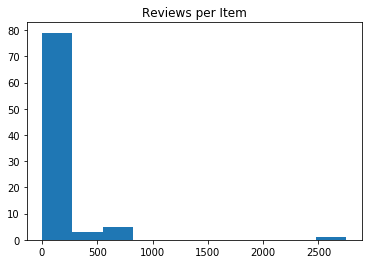

In [31]:
plt.hist(df.groupby("itemID")['reviewerID'].count())
plt.title("Reviews per Item")
#plt.xaxis("# Reviews")

Mean: 4.50
Median: 5.0


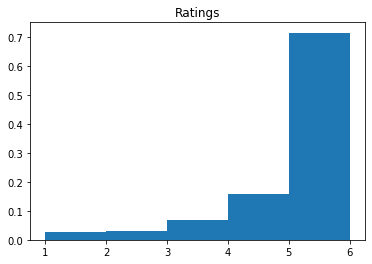

In [32]:
hist = plt.hist(df['overall'], bins=[1,2,3,4,5,6], density=True)
plt.title('Ratings')
print("Mean: %.2f" % df['overall'].mean())
print("Median: %.1f" % df['overall'].median())

## Content

In [33]:
# tokenise content

In [34]:
row = 10 

sent = df['reviewText'].iloc[row]

print(len(sent))
print(sent)

477
Maybe It's Not As Bad As You Think So, you think you have problems? Things could be worse and this clever book can prove it. The king starts out with a problem. The mice are eating his cheese. The more he tries to fix the problem, the worse it gets. The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all. The solution requires cooperation from the king and the mice. It involves the cheese.


In [35]:
stop_words = list(set(stopwords.words('english')))
sent_tokenize(sent)

["Maybe It's Not As Bad As You Think So, you think you have problems?",
 'Things could be worse and this clever book can prove it.',
 'The king starts out with a problem.',
 'The mice are eating his cheese.',
 'The more he tries to fix the problem, the worse it gets.',
 "The king finally arranges to bring back the mice when he comes to the realization that his original dilemma  wasn't so intolerable after all.",
 'The solution requires cooperation from the king and the mice.',
 'It involves the cheese.']

In [36]:
#tokenise, punctuation, lower-case
tokens = [word.lower() for sent in sent_tokenize(sent) for word in word_tokenize(sent) if word.isalpha()]

#filter stop words
#tokens = [word for word in tokens if word not in stop_words]

print(len(tokens))

88


In [37]:
#stemming?
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in tokens]
" ".join(stemmed)

'mayb it not as bad as you think so you think you have problem thing could be wors and thi clever book can prove it the king start out with a problem the mice are eat hi chees the more he tri to fix the problem the wors it get the king final arrang to bring back the mice when he come to the realiz that hi origin dilemma wa so intoler after all the solut requir cooper from the king and the mice it involv the chees'

In [38]:
review_length = df['reviewText'].apply(lambda x: len(x))
df[df['reviewText'].apply(lambda x: len(x)) < 10].count()

#plt.hist(review_length)

overall       5
verified      5
reviewTime    5
reviewerID    5
itemID        5
reviewText    5
dtype: int64

In [41]:
%%time
#if 'cleanedText' not in df.columns:
df['cleanedText'] = df['reviewText'].apply(lambda x: clean_text(x))
df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))

CPU times: user 12.9 s, sys: 109 ms, total: 13.1 s
Wall time: 13.2 s


In [293]:
df[df['cleanedText'].apply(lambda x: len(x)) < 10].count()

overall        6
verified       6
reviewTime     6
reviewerID     6
itemID         6
reviewText     6
cleanedText    6
dtype: int64

In [335]:
df[df['cleanedText'].apply(lambda x: len(x)) < 1].count()

overall        3
verified       3
reviewTime     3
reviewerID     3
itemID         3
reviewText     3
cleanedText    3
dtype: int64

In [344]:
df[df['cleanedText'].apply(lambda x: len(x)) < 1]

,overall,verified,reviewTime,reviewerID,itemID,reviewText,cleanedText,reviewWords
4813,5,True,2017-08-30,A18WUVMHPTVYQ8,0001844423,100% 100%,,0
4982,5,True,2016-12-29,A197527ILE0LL8,0001844423,5stars 5stars,,0
9967,5,False,2016-06-20,A2PU9Z67Q8VRRM,0001713256,A+ A+,,0


In [340]:
#df['reviewWords'] = df['cleanedText'].apply(lambda x: len(x.split()))

In [341]:
df['reviewWords'].sort_values(ascending=False).head(10)

6405    4855
7395    2882
6406    2823
6407    2451
5936    2113
7034    2010
6408    1962
8429    1874
5230    1866
6804    1637
Name: reviewWords, dtype: int64

In [145]:
'''
tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokeniser.convert_tokens_to_ids(tokeniser.tokenize("Let's see all hidden-states and attentions on this text")))
'''


'\ntokeniser = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nprint(tokeniser.convert_tokens_to_ids(tokeniser.tokenize("Let\'s see all hidden-states and attentions on this text")))\n'

In [113]:
user_dict = {}

In [114]:
%%time

added = 0
updated = 0

for u, group in tqdm(df.groupby('reviewerID')):
    #print(u)
    
    if u not in user_dict:
        user_dict[u] = {}
        user_dict[u]['n_reviews'] = group['itemID'].count()
        user_dict[u]['m_rating'] = group['overall'].mean()
        user_dict[u]['m_words'] = group['reviewWords'].mean()
        added+=1
    else:
        user_dict[u]['n_reviews'] += group['itemID'].count()
        user_dict[u]['m_rating'] = np.mean([user_dict[u]['m_rating'], group['overall'].mean()])
        user_dict[u]['m_words'] = np.mean([user_dict[u]['m_words'], group['reviewWords'].mean()])
        updated+=1

print("Added: %.0f" % added)
print("Updated: %.0f" % updated)
print("Total users: %.0f" % len(user_dict.keys()))

100%|██████████| 8908/8908 [00:06<00:00, 1376.91it/s]

Added: 8908
Updated: 0
Total users: 8908
CPU times: user 6.81 s, sys: 63.9 ms, total: 6.87 s
Wall time: 6.83 s


(array([7.969e+03, 6.780e+02, 1.750e+02, 4.800e+01, 2.200e+01, 8.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 3.000e+00]),
 array([   0.        ,  208.07777778,  416.15555556,  624.23333333,
         832.31111111, 1040.38888889, 1248.46666667, 1456.54444444,
        1664.62222222, 1872.7       , 2080.77777778]),
 <a list of 10 Patch objects>)

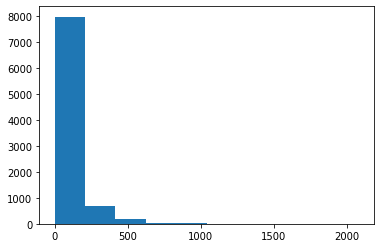

In [95]:
n_reviews_data = []
m_words_data = []


for u, values in user_dict.items():
    n_reviews_data.append(values['n_reviews'])
    m_words_data.append(values['m_words'])
    
#plt.hist(n_reviews_data)
plt.hist(m_words_data)

In [96]:
# TODO: plot distributions in with meaningful bin sizes/intervals, e.g. 1-2, 3-4, 5-7, >8

In [98]:
item_dict = {}

In [110]:
%%time

for item, group in tqdm(df.groupby('itemID')):
    #print(item)
    
    if item not in item_dict:
        item_dict[item] = {}
        item_dict[item]['n_reviews'] = group['reviewerID'].count()
        item_dict[item]['m_rating'] = group['overall'].mean()
        item_dict[item]['m_words'] = group['reviewWords'].mean()
    else:
        item_dict[item]['n_reviews'] += group['reviewerID'].count()
        item_dict[item]['m_rating'] = np.mean([item_dict[item]['m_rating'], group['overall'].mean()])
        item_dict[item]['m_words'] = np.mean([item_dict[item]['m_words'], group['reviewWords'].mean()])

        
len(item_dict.keys())

100%|██████████| 88/88 [00:00<00:00, 803.26it/s]

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 124 ms


89

Mean: 100.0
Median: 80.7


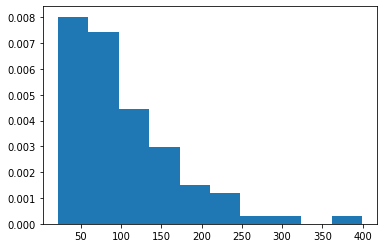

In [109]:
n_reviews_data = []
m_words_data = []


for u, values in item_dict.items():
    n_reviews_data.append(values['n_reviews'])
    m_words_data.append(values['m_words'])
    
#plt.hist(n_reviews_data)
plt.hist(m_words_data, density=True)
print("Mean: %.1f" % np.mean(m_words_data))
print("Median: %.1f" %np.median(m_words_data))